In [1]:
import pandas as pd
import scipy as sc
import time
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from operator import truediv, mul

# Data_cleaned

In [2]:
data_cleaned = pd.read_csv("data/data_cleaned.csv")
label = data_cleaned["Categorie1"].values
label_1=[]
label_2=[]
label_3=[]
label_4=[]
for k in label:
    if k=="TELEPHONIE - GPS":
        label_1+=[1]
        label_2+=[0]
        label_3+=[0]
        label_4+=[0]
    elif k=="INFORMATIQUE":
        label_1+=[0]
        label_2+=[1]
        label_3+=[0]
        label_4+=[0]
    elif k=="LIBRAIRIE":
        label_1+=[0]
        label_2+=[0]
        label_3+=[1]
        label_4+=[0]
    elif k=="VETEMENTS - LINGERIE " :
        label_1+=[0]
        label_2+=[0]
        label_3+=[0]
        label_4+=[1]
    else:
        label_1+=[0]
        label_2+=[0]
        label_3+=[0]
        label_4+=[0]
        
features = sc.sparse.load_npz("data/feature_sparse.npz")

In [4]:
#X:descriptions, Y:categories
X_train, X_test, y_train, y_test = train_test_split(features, label, test_size=0.1, random_state=42)

In [5]:
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(features, label_1, test_size=0.1, random_state=42)
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(features, label_2, test_size=0.1, random_state=42)
X_train_3, X_test_3, y_train_3, y_test_3 = train_test_split(features, label_3, test_size=0.1, random_state=42)
X_train_4, X_test_4, y_train_4, y_test_4 = train_test_split(features, label_4, test_size=0.1, random_state=42)

### Apprentissage par classe:

In [6]:
lr_1= LogisticRegression()
lr_1.fit(X_train_1,y_train_1)
train_score_1 = lr_1.score(X_train_1,y_train_1)
print(train_score_1)

/Users/paulbrunet/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.9934444444444445


In [7]:
lr_2= LogisticRegression()
lr_2.fit(X_train_2,y_train_2)
train_score_2 = lr_2.score(X_train_2,y_train_2)
print(train_score_2)

0.9930444444444444


In [8]:
lr_3= LogisticRegression()
lr_3.fit(X_train_3,y_train_3)
train_score_3 = lr_3.score(X_train_3,y_train_3)
print(train_score_3)

0.9973222222222222


In [9]:
lr_4= LogisticRegression()
lr_4.fit(X_train_4,y_train_4)
train_score_4 = lr_4.score(X_train_4,y_train_4)
print(train_score_4)

0.9959666666666667


### Apprentissage mutliclasse

In [10]:
ts = time.time()
lr = LogisticRegression()
lr.fit(X_train, y_train)
te = time.time()
print(te-ts, "sec")
train_score = lr.score(X_train,y_train) 
print(train_score) #Nombre de descriptions dont la prédiction est juste/Nombre de descriptions total

/Users/paulbrunet/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


50.615036964416504 sec
0.9789444444444444


### Prediction

In [11]:
predict_1 = lr_1.predict(X_train_1)

In [12]:
predict_2 = lr_2.predict(X_train_2)

In [13]:
predict_3 = lr_3.predict(X_train_3)

In [14]:
predict_4 = lr_4.predict(X_train_4)

In [15]:
predict = lr.predict(X_train)

In [16]:
test_score = lr.score(X_test,y_test)
print("Score multi-class :",test_score, "\n")

print("Scores pour les regressions log binaires : \n")
test_score_1 = lr_1.score(X_test_1,y_test_1)
print("  Score TEL-GPS :",test_score_1, "\n")
test_score_2 = lr_2.score(X_test_2,y_test_2)
print("  Score INFO :",test_score_2, "\n")
test_score_3 = lr_3.score(X_test_3,y_test_3)
print("  Score LIB :",test_score_3, "\n")
test_score_4 = lr_4.score(X_test_4,y_test_4)
print("  Score VETEMENTS :",test_score_4, "\n")

Score multi-class : 0.9015 

Scores pour les regressions log binaires : 

  Score TEL-GPS : 0.9876 

  Score INFO : 0.9862 

  Score LIB : 0.9867 

  Score VETEMENTS : 0.9854 



In [17]:
def cross_cat(predictee,trainee):
    pred_cat = predictee==1
    train_cat = np.array(trainee)==1
    TP=0
    FN=0
    FP=0
    TN=0
    cross_tab = pd.crosstab(train_cat, pred_cat, rownames=["Ground True"], colnames=["Prediction"])
    #cross_tab = A.divide(A.sum(axis=1),axis=0)*100
    print(cross_tab)
    TP=cross_tab[1][1] #ok
    FN=cross_tab[0][1]
    FP=cross_tab[1][0]
    TN=cross_tab[0][0] #ok
    return len(trainee),TP,FN,FP,TN

In [18]:
nb_data_1,TP_1,FN_1,FP_1,TN_1=cross_cat(predict_1,y_train_1)
nb_data_2,TP_2,FN_2,FP_2,TN_2=cross_cat(predict_2,y_train_2)
nb_data_3,TP_3,FN_3,FP_3,TN_3=cross_cat(predict_3,y_train_3)
nb_data_4,TP_4,FN_4,FP_4,TN_4=cross_cat(predict_4,y_train_4)

cat= ["TELEPHONIE - GPS","INFORMATIQUE","LIBRAIRIE","VETEMENTS - LINGERIE "]
TP =[TP_1,TP_2,TP_3,TP_4]  #Vrai predit Vrai
TN = [TN_1,TN_2,TN_3,TN_4] #Faux predit faux


FP = [FP_1,FP_2,FP_3,FP_4] #Faux predit Vrai
FN = [FN_1,FN_2,FN_3,FN_4] #Vrai predit faux

Prediction   False  True 
Ground True              
False        70642    185
True           405  18768
Prediction   False  True 
Ground True              
False        76656    160
True           466  12718
Prediction   False  True 
Ground True              
False        78938    165
True            76  10821
Prediction   False  True 
Ground True              
False        84491    110
True           253   5146


In [19]:
#à comparer avec l'apprentissage sur toutes les classes !

for cat_name in cat :
    predict_cat = predict==cat_name
    y_train_cat = np.array(y_train)==cat_name
    cross_tab = pd.crosstab(y_train_cat, predict_cat, rownames=["Ground True"], colnames=["Prediction"])
    #cross_tab = A.divide(A.sum(axis=1),axis=0)*100
    print(cross_tab, '\n')
    TP += [cross_tab[1][1]]
    FP += [cross_tab[1][0]]
    TN += [cross_tab[0][0]]
    FN += [cross_tab[0][1]]

Prediction   False  True 
Ground True              
False        70541    286
True           131  19042 

Prediction   False  True 
Ground True              
False        76604    212
True           223  12961 

Prediction   False  True 
Ground True              
False        78400    703
True             1  10896 

Prediction   False  True 
Ground True              
False        84483    118
True            68   5331 



In [20]:
PFP=np.zeros(len(FP)) 
PFN=np.zeros(len(FN)) 
err=np.zeros(len(TP)) 
err2=np.zeros(len(TP)) 
for i in range(len(TP)) : 
    PFP[i] = FP[i]/(FP[i]+TN[i])*100
    PFN[i] = FN[i]/(FN[i]+TP[i])*100 
    err[i] = PFP[i]+PFN[i]
    err2[i] = (FN[i]+FP[i])/90000 * 100

    
cat = ["TELEPHONIE - GPS","INFORMATIQUE","LIBRAIRIE","VETEMENTS - LINGERIE ","GPS_mul","INFO_mul","LIB_mul","VET_mul"]

In [21]:
print(err)
print(err2)

[2.37354531 3.74287732 0.90602846 4.81607508 1.0870533  1.96742834
 0.89789155 1.39897076]
[0.65555556 0.69555556 0.26777778 0.40333333 0.46333333 0.48333333
 0.78222222 0.20666667]


In [22]:
def bar_plot_false(cat,PFN,PFP):
    fig = plt.figure(figsize=(10,10))
    plt.bar(cat,PFP,width = 0.5, color = 'blue', label="% faux positif")
    plt.bar(cat,PFN,width = 0.5, color = 'orange', label="% faux negatif")
    plt.title("Pourcentage de mauvaise prediction")
    plt.legend()
    fig.autofmt_xdate(rotation=45)

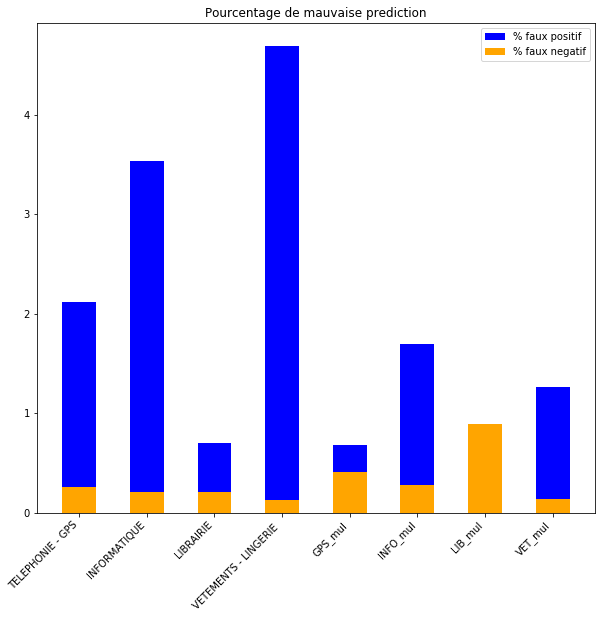

In [23]:
bar_plot_false(cat,PFP,PFN)

In [24]:
def bar_plot_error(cat,err):
    fig = plt.figure(figsize=(10,10))
    plt.bar(cat,err,width = 0.5, color = 'green', label="Error")
    plt.title("Erreur de prediction")
    plt.legend()
    fig.autofmt_xdate(rotation=45)

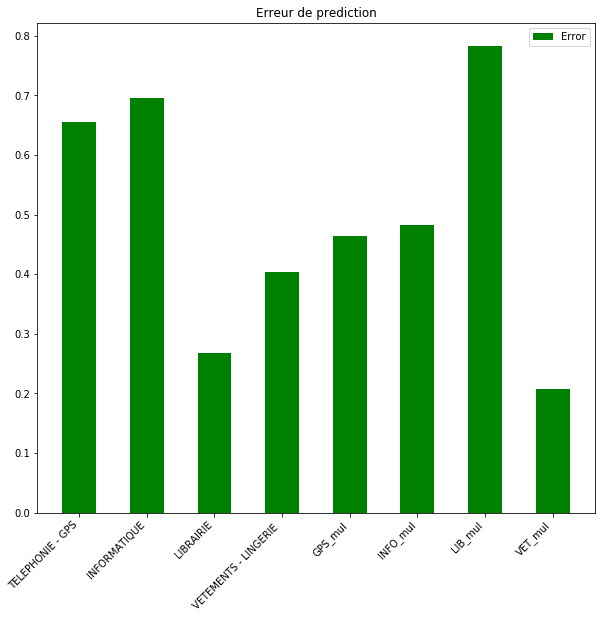

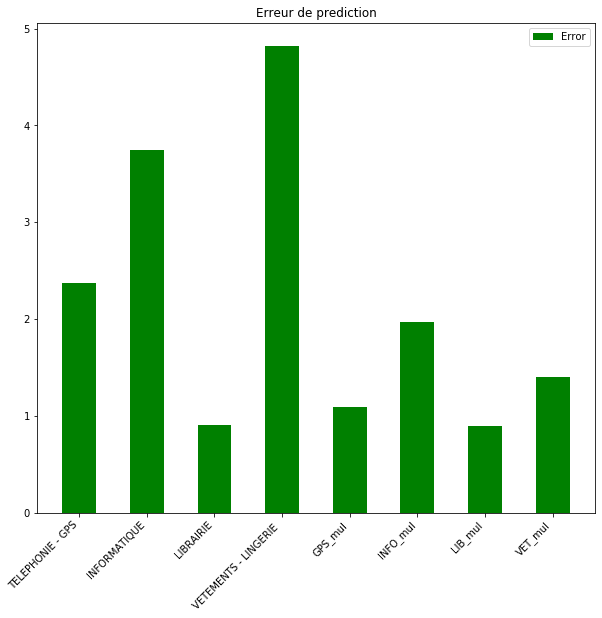

In [25]:
bar_plot_error(cat,err2)
bar_plot_error(cat,err)

### Comments : 

* Prediction meilleure en logistique multiclasse pour les catégorie Tel-GPS et Info par contre prediction meilleure pour librairie en logistique binaire.

* La raison ? Librairie a bcp moins de données dans la data set que Tel-GPS et Info ce qui pourrait expliquer que lorsqu'on a fait un apprentissage en logistique multiclasse l'erreur est plus importante que lorsque qu'on apprend en log binaire.


## Reduction X train

In [26]:
nb = [10000,50000,70000]

X_mul_1 = X_train[0:nb[0]] #multi sur 10k
y_mul_1 = y_train[0:nb[0]]

X_mul_2 = X_train[0:nb[1]] #multi sur 50k
y_mul_2 = y_train[0:nb[1]]


X_mul_3 = X_train[0:nb[2]] #multi sur 70k
y_mul_3 = y_train[0:nb[2]]


X_gps_1 = X_train_1[0:nb[0]] #GPS
y_gps_1 = y_train_1[0:nb[0]]

X_gps_2 = X_train_1[0:nb[1]] #GPS
y_gps_2 = y_train_1[0:nb[1]]

X_gps_3 = X_train_1[0:nb[2]] #GPS
y_gps_3 = y_train_1[0:nb[2]]

In [27]:
#nos regresseurs 
lr_mul_1 = LogisticRegression()
lr_mul_2 = LogisticRegression()
lr_mul_3 = LogisticRegression()

lr_gps_1 = LogisticRegression()
lr_gps_2 = LogisticRegression()
lr_gps_3 = LogisticRegression()

#regression mul sur 10k, 50k, 70k
lr_mul_1.fit(X_mul_1, y_mul_1)
lr_mul_2.fit(X_mul_2, y_mul_2)
lr_mul_3.fit(X_mul_3, y_mul_3)


#regression binaire sur 10k, 50k, 70k
lr_gps_1.fit(X_gps_1,y_gps_1)
lr_gps_2.fit(X_gps_2,y_gps_2)
lr_gps_3.fit(X_gps_3,y_gps_3)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [28]:
#predictions avec nos regresseurs multinomiales
predict_mul_1=lr_mul_1.predict(X_test)
predict_mul_2=lr_mul_2.predict(X_test)
predict_mul_3=lr_mul_3.predict(X_test)

In [29]:
#extraction des réponses predites GPS avec nos regresseurs mul
predict_gps_1 = predict_mul_1=="TELEPHONIE - GPS"
predict_gps_2 = predict_mul_2=="TELEPHONIE - GPS"
predict_gps_3 = predict_mul_3=="TELEPHONIE - GPS"

y_test_gps = np.array(y_test)=="TELEPHONIE - GPS"


cross_tab_1 = pd.crosstab(y_test_gps, predict_gps_1, rownames=["Ground True"], colnames=["Prediction"])
cross_tab_2 = pd.crosstab(y_test_gps, predict_gps_2, rownames=["Ground True"], colnames=["Prediction"])
cross_tab_3 = pd.crosstab(y_test_gps, predict_gps_3, rownames=["Ground True"], colnames=["Prediction"])

#calcul des scores sur GPS avec les reg mul
score_mul_1= sum(np.diag(cross_tab_1))/sum(cross_tab_1.sum())
score_mul_2= sum(np.diag(cross_tab_2))/sum(cross_tab_2.sum())
score_mul_3= sum(np.diag(cross_tab_3))/sum(cross_tab_3.sum())

In [30]:
print("Affichage des scores de test: \n")
print("   Données GPS issues de la regMultinomiale \n")
print(score_mul_1, "pour ", len(y_mul_1), "données d'apprentissage" )
print(score_mul_2, "pour ", len(y_mul_2), "données d'apprentissage" )
print(score_mul_3, "pour ", len(y_mul_3), "données d'apprentissage \n")
print("  Données GPS issues de la regBinaire \n")
print(lr_gps_1.score(X_test_1,y_test_1), "pour ", len(y_gps_1), "données d'apprentissage" )
print(lr_gps_2.score(X_test_1,y_test_1), "pour ", len(y_gps_2), "données d'apprentissage" )
print(lr_gps_3.score(X_test_1,y_test_1), "pour ", len(y_gps_3), "données d'apprentissage \n" )

Affichage des scores de test: 

   Données GPS issues de la regMultinomiale 

0.979 pour  10000 données d'apprentissage
0.9873 pour  50000 données d'apprentissage
0.9886 pour  70000 données d'apprentissage 

  Données GPS issues de la regBinaire 

0.9778 pour  10000 données d'apprentissage
0.9851 pour  50000 données d'apprentissage
0.9873 pour  70000 données d'apprentissage 



### Comments :

- Ok donc la prediction est moins bonne ce qui est logique car il y a moins de données d'apprentissage au préalable
- Peut etre essayer que sur les 3 plus grandes catégories voir ce que ça donne ?